In [13]:
import networkx as nx
import numpy as np
import torch

import os
import datetime
import shutil

import torch.optim as optimizer
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transf
from torchsummary import summary

import numpy as np
import pandas as pd
import random
from skimage import io
from data_feed import DataFeed_image_pos
import matplotlib.pyplot as plt

In [14]:
# year month day 
dayTime = datetime.datetime.now().strftime('%m-%d-%Y')
# Minutes and seconds 
hourTime = datetime.datetime.now().strftime('%H_%M')
print(dayTime + '\n' + hourTime)
dataset_dir = './image_beam/'
pwd = os.getcwd() + '//' + 'saved_folder' + '//' + dayTime + '_' + hourTime 
print(pwd)
# Determine whether the folder already exists
isExists = os.path.exists(pwd)
if not isExists:
    os.makedirs(pwd)    

12-31-2024
14_14
C:\Users\aghalkha21\Downloads\Git_Projects\Carla//saved_folder//12-31-2024_14_14


In [15]:
pos_path = "./pos_height_beam/scenario23_pos_height_beam.csv"
images_path = "./image_beam/scenario23_img_beam.csv"
pos_dataset = pd.read_csv(pos_path)
image_dataset = pd.read_csv(images_path)

In [16]:
pos_dataset.describe()

,index,unit2_lat,unit2_lon,unit2_height,unit2_distance,unit1_beam
count,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000,11387.000000
mean,5694.000000,0.342214,0.395211,0.318174,0.288409,15.227013
std,3287.288092,0.151951,0.115469,0.264798,0.169777,4.918251
min,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,2847.500000,0.230261,0.342666,0.092153,0.173748,14.000000
50%,5694.000000,0.309431,0.410203,0.204380,0.238590,16.000000
75%,8540.500000,0.398631,0.448638,0.535584,0.368189,17.000000
max,11387.000000,1.000000,1.000000,1.000000,1.000000,30.000000


In [17]:
concat_data = pd.merge(pos_dataset, image_dataset, left_index=True, right_index=True)
concat_data = concat_data.drop(columns=["unit1_beam_y", "index_y"])

# Function to swap two columns
def swap_columns(df, col1, col2):
    cols = list(df.columns)
    idx1, idx2 = cols.index(col1), cols.index(col2)
    cols[idx1], cols[idx2] = cols[idx2], cols[idx1]
    return df[cols]

# Swap columns 'A' and 'C'
concat_data = swap_columns(concat_data, 'unit1_beam_x', 'unit1_rgb')

#concat_data = concat_data[["unit1_beam_x", "unit1_rgb"]]

In [18]:
concat_data.head()

,index_x,unit2_lat,unit2_lon,unit2_height,unit2_distance,unit1_rgb,unit1_beam_x
0,1,0.319556,0.487488,0.000000,0.087753,././datasets/scenario23_dev//unit1/camera_data...,22
1,2,0.317678,0.486797,0.002737,0.089964,././datasets/scenario23_dev//unit1/camera_data...,22
2,3,0.316038,0.486105,0.004562,0.092113,././datasets/scenario23_dev//unit1/camera_data...,22
3,4,0.314589,0.485414,0.009124,0.095125,././datasets/scenario23_dev//unit1/camera_data...,22
4,5,0.312354,0.484446,0.012774,0.097287,././datasets/scenario23_dev//unit1/camera_data...,20


In [19]:
modalities = ["pos_height", "images"]
num_users = 20
min_modality = 1
weights = [0.3, 0.5]

# Generate modality assignments
user_modalities = [
    list(set(random.choices(modalities, weights=weights, k=min_modality)
             + random.choices(modalities, weights=weights, k=1)))
    for _ in range(num_users)
]

# Output the result
for i, modalities_for_user in enumerate(user_modalities, 1):
    print(f"User {i}: {modalities_for_user}")


User 1: ['images', 'pos_height']
User 2: ['images', 'pos_height']
User 3: ['images', 'pos_height']
User 4: ['images']
User 5: ['images']
User 6: ['images', 'pos_height']
User 7: ['images', 'pos_height']
User 8: ['images', 'pos_height']
User 9: ['images', 'pos_height']
User 10: ['images', 'pos_height']
User 11: ['images', 'pos_height']
User 12: ['pos_height']
User 13: ['images']
User 14: ['images']
User 15: ['images', 'pos_height']
User 16: ['images']
User 17: ['images', 'pos_height']
User 18: ['images']
User 19: ['images']
User 20: ['images']


In [22]:
img_resize = transf.Resize((224, 224))
img_norm = transf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
proc_pipe = transf.Compose(
    [transf.ToPILImage(),
     img_resize,
     transf.ToTensor(),
     img_norm]
)

dataset = DataFeed_image_pos(data_csv=concat_data, transform=proc_pipe, modalities=["pos_height", "images"])

# Step 3: Test __len__
assert len(dataset) == 11387, f"Expected length 11387, got {len(dataset)}"

# Step 4: Test __getitem__
for idx in range(1):
    try:
        sample = dataset[idx]
        assert isinstance(sample, tuple), f"Expected tuple, got {type(sample)}"
        if "pos_height" in dataset.modalities:
            assert len(sample[0]) == 4, f"Expected 4 features, got {len(sample[0])}"
        if "images" in dataset.modalities:
            assert sample[1] is not None, f"Image is None at index {idx}"
        print(f"Sample {idx}: {sample}")
    except Exception as e:
        print(f"Error in sample {idx}: {e}")

# Step 5: Test modalities filtering
dataset.modalities = ["pos_height"]
sample = dataset[0]
assert len(sample) == 2, f"Expected 2 elements, got {len(sample)} (pos_height only)"

dataset.modalities = ["pos_height"]
sample = dataset[0]
assert len(sample) == 2, f"Expected 2 elements, got {len(sample)} (images only)"


# Step 6: Test DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
for _, (batch_idx, batch) in zip(range(1), enumerate(dataloader)):
    print(f"Batch {batch_idx}: {batch}")


Sample 0: (array([0.31955603, 0.4874879 , 0.        , 0.08775272], dtype=float32), tensor([[[-0.5596, -0.5424, -0.5424,  ...,  1.7694,  1.8379,  1.8893],
         [-0.5767, -0.5424, -0.5424,  ...,  1.7523,  1.8208,  1.8722],
         [-0.5767, -0.5424, -0.5424,  ...,  1.7180,  1.8037,  1.8722],
         ...,
         [-0.5938, -0.5938, -0.6109,  ..., -0.3541, -0.3541, -0.3541],
         [-0.5938, -0.5767, -0.5767,  ..., -0.3369, -0.3541, -0.3541],
         [-0.5767, -0.5767, -0.5938,  ..., -0.3369, -0.3541, -0.3541]],

        [[ 0.2927,  0.2927,  0.2752,  ...,  2.3585,  2.3761,  2.3936],
         [ 0.2927,  0.2752,  0.2752,  ...,  2.3410,  2.3761,  2.3936],
         [ 0.2927,  0.2927,  0.2752,  ...,  2.3410,  2.3936,  2.3936],
         ...,
         [ 0.3452,  0.3452,  0.3277,  ...,  0.4853,  0.4678,  0.4678],
         [ 0.3452,  0.3627,  0.3627,  ...,  0.4853,  0.4678,  0.4678],
         [ 0.3627,  0.3627,  0.3452,  ...,  0.4853,  0.4678,  0.4678]],

        [[ 1.1237,  1.1237,  1.10

In [23]:
import seaborn as sns

In [24]:
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11387 entries, 0 to 11386
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index_x         11387 non-null  int64  
 1   unit2_lat       11387 non-null  float64
 2   unit2_lon       11387 non-null  float64
 3   unit2_height    11387 non-null  float64
 4   unit2_distance  11387 non-null  float64
 5   unit1_rgb       11387 non-null  object 
 6   unit1_beam_x    11387 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 622.9+ KB


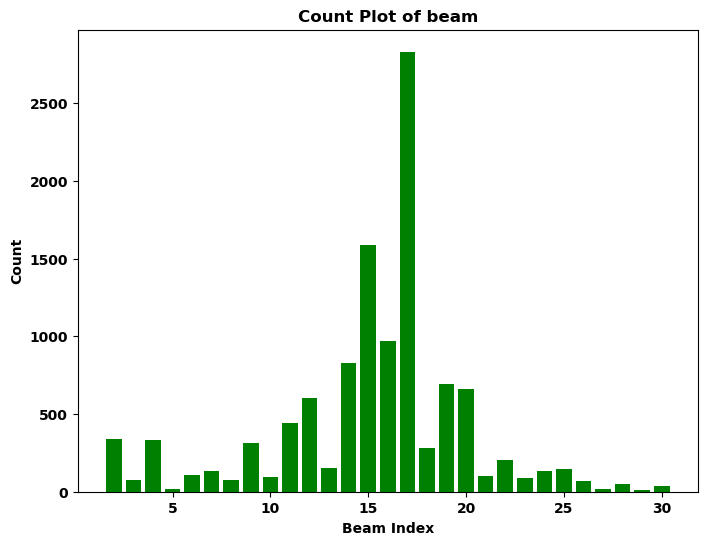

In [25]:
# univariate analysis using plots
df = concat_data
quality_counts = df["unit1_beam_x"].value_counts()

# using Matplotlib to create a count plot 
plt.figure(figsize=(8, 6)) #Figure size in inches
plt.bar(quality_counts.index, quality_counts, color='green')
plt.title("Count Plot of beam")
plt.xlabel("Beam Index")
plt.ylabel("Count")
plt.show()

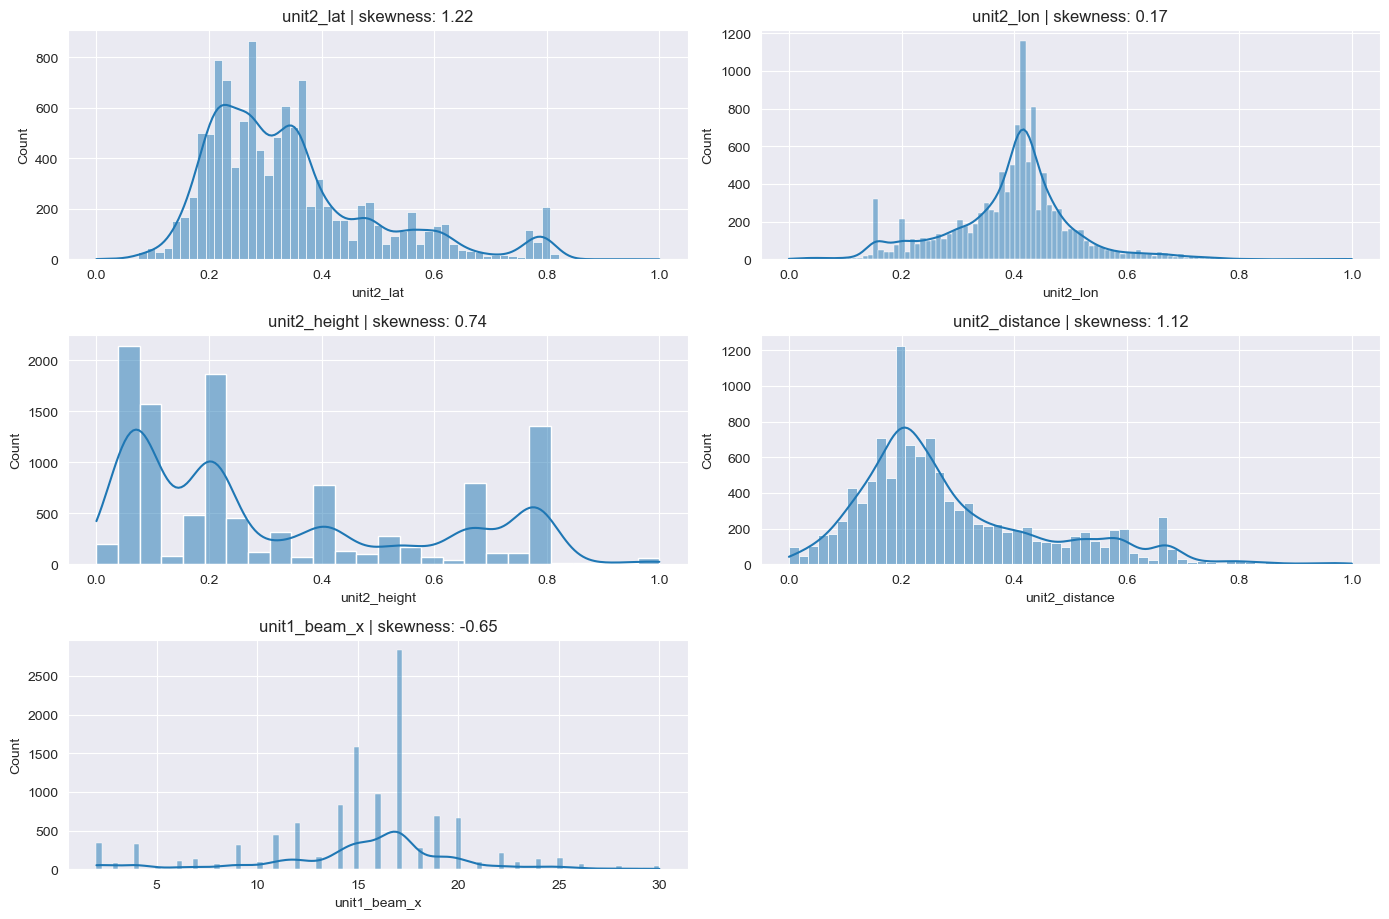

In [35]:
# Set seaborn style
sns.set_style("darkgrid")

# Identify numerical columns 
numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns
numerical_columns = numerical_columns.drop("index_x")

plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | skewness: {round(df[feature].skew(), 2)}")


# Adjust the layout and show plots 
plt.tight_layout()
plt.show()

In [58]:
np.random.seed(42)
test_df = pd.DataFrame({
    'unit1_beam_x': np.random.randint(1, 11, size=1000),  # 10 classes
    'feature1': np.random.randint(1, 11, size=1000),
    'feature2': np.random.randint(1, 11, size=1000)
})


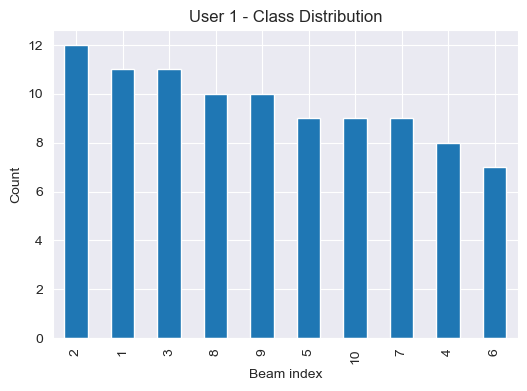

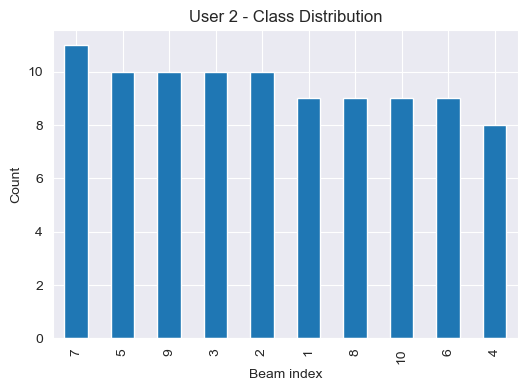

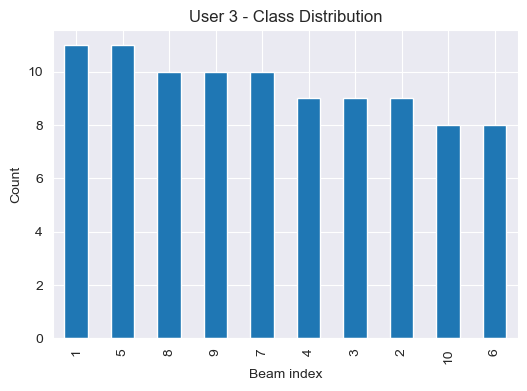

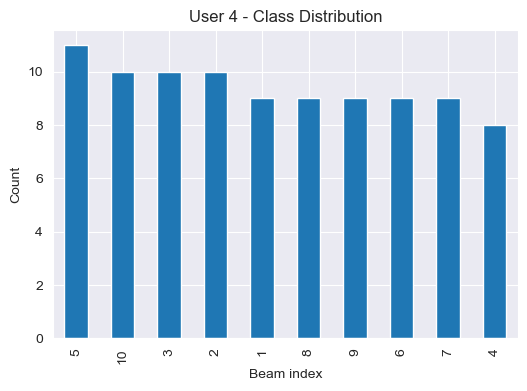

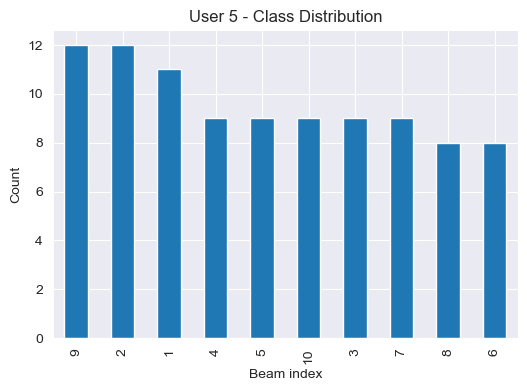

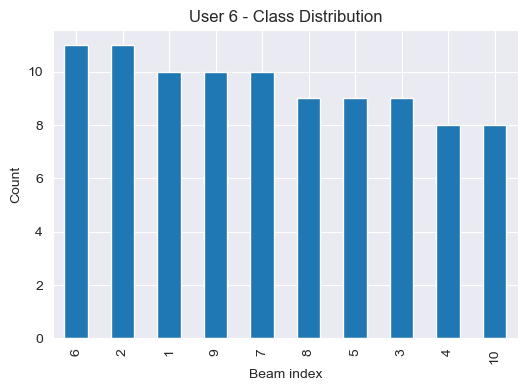

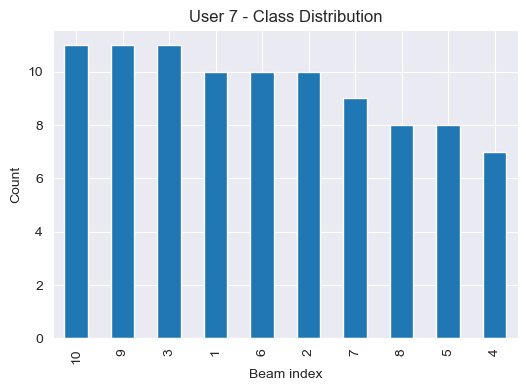

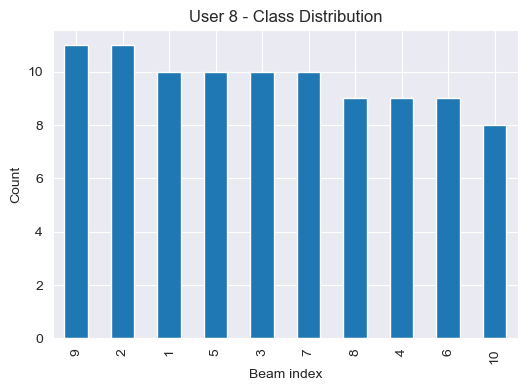

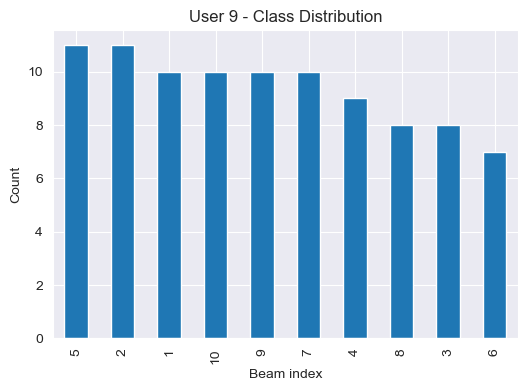

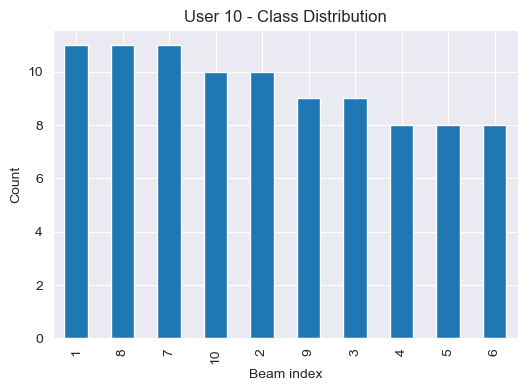

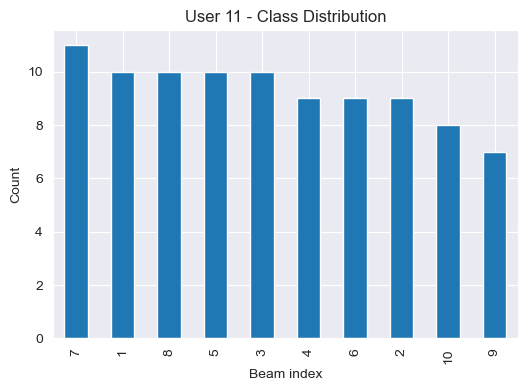

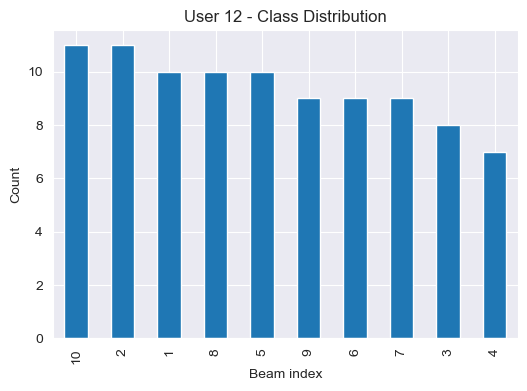

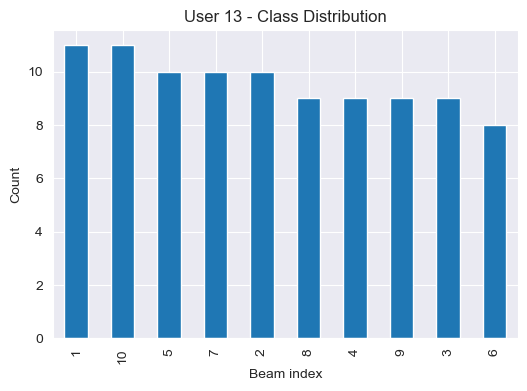

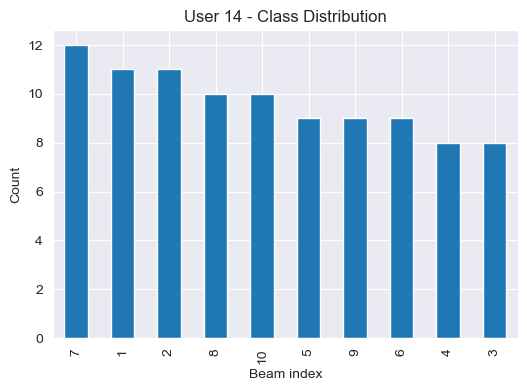

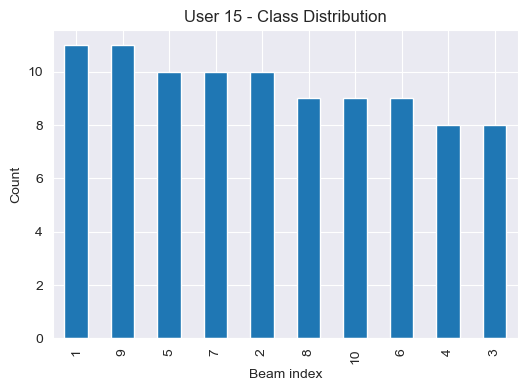

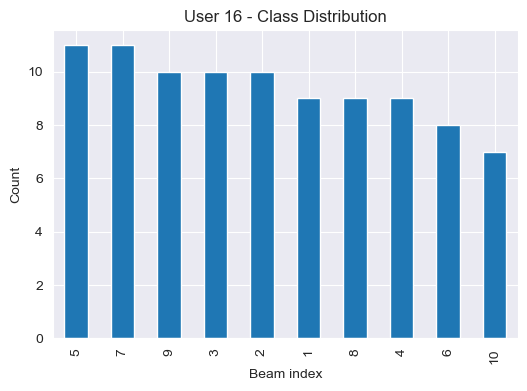

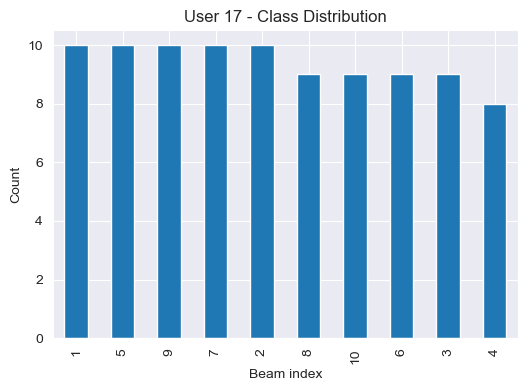

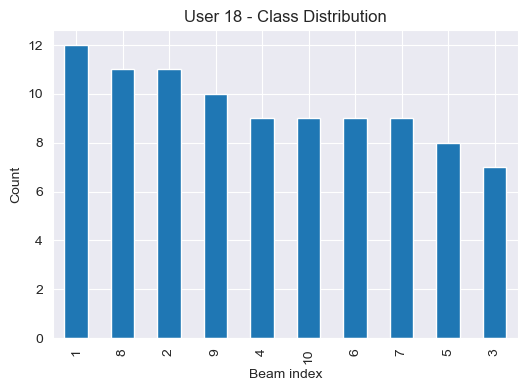

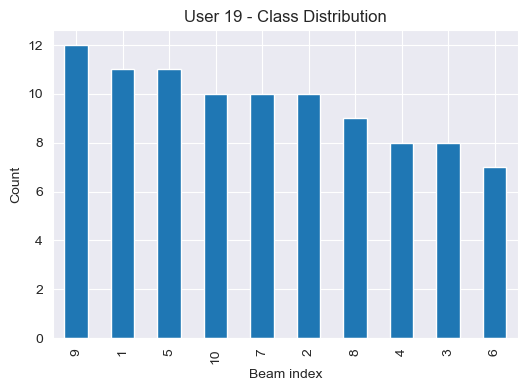

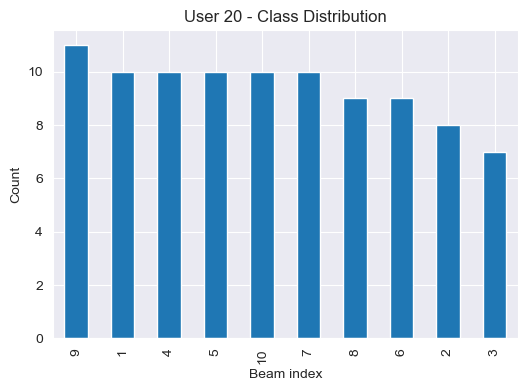

In [71]:
import numpy as np
import pandas as pd
from scipy.stats import zipf, dirichlet
import matplotlib.pyplot as plt

# Example dataset (Replace with your actual data loading process)
df = test_df #pd.read_csv('your_file.csv')

# Number of users to split the data into
num_users = 20

# Number of classes in the dataset (replace with actual number of classes in your dataset)
num_classes = len(df['feature1'].unique())  # Assuming the dataset has a 'category' column

# Step 1: Apply Zipf Distribution to Simulate Class Skew
# Zipf's law with parameter σ
zipf_param = 1.01  # Zipf parameter (σ)

# Generate class frequencies from Zipf distribution
class_frequencies = zipf.rvs(zipf_param, size=num_classes)

# Normalize to sum to the total number of data points in your dataset
total_samples = len(df)
class_probabilities = class_frequencies / class_frequencies.sum()

# Create a list of class samples (simulating the non-IID dataset)
class_samples = []
for i, prob in enumerate(class_probabilities):
    class_samples.append(df[df['feature1'] == df['feature1'].unique()[i]])

# Step 2: Apply Dirichlet Distribution for User Allocation
# Dirichlet parameter (α)
dirichlet_param = 100  # Dirichlet parameter (α) for imbalance

# Generate Dirichlet-distributed probabilities for user class proportions
user_class_probs = dirichlet.rvs([dirichlet_param] * num_classes, size=num_users)

# Step 3: Assign Data to Users Based on Class Proportions
user_dfs = [[] for _ in range(num_users)]

# Loop through each class, and assign data to users based on Dirichlet probabilities
for class_idx, class_data in enumerate(class_samples):
    user_class_prob = user_class_probs[:, class_idx]  # Proportions for each user for this class
    num_samples_in_class = len(class_data)

    for user_idx, prob in enumerate(user_class_prob):
        num_samples_for_user = int(prob * num_samples_in_class)
        user_dfs[user_idx].append(class_data.sample(n=num_samples_for_user))

# Combine user samples into final datasets
final_user_dfs = [pd.concat(user_data) for user_data in user_dfs]

# Optionally, save each user's dataset to a CSV file
for i, user_df in enumerate(final_user_dfs):
    user_df.to_csv(f'user_{i+1}_data.csv', index=False)

# Plot the distribution of classes in each user's data for visualization
for i, user_df in enumerate(final_user_dfs):
    plt.figure(figsize=(6, 4))
    user_df['feature1'].value_counts().plot(kind='bar', title=f"User {i+1} - Class Distribution")
    plt.xlabel('Beam index')
    plt.ylabel('Count')
    plt.show()

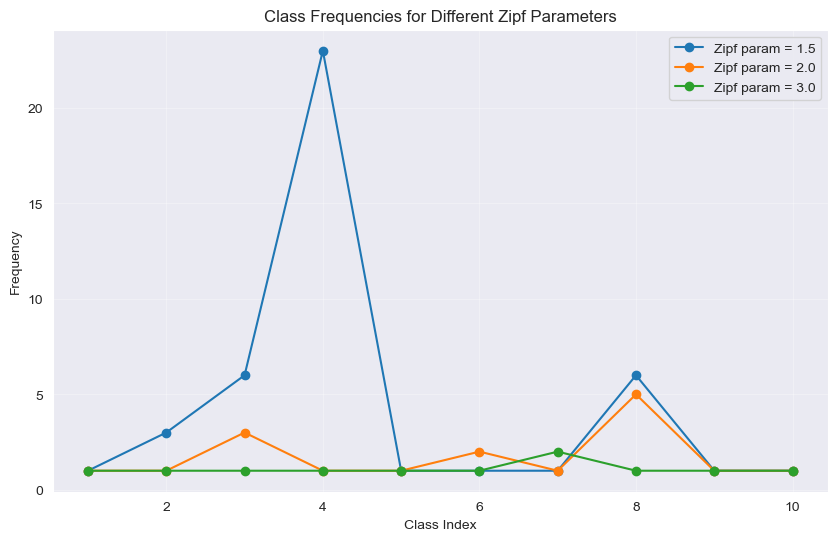

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zipf

num_classes = 10
zipf_params = [1.5, 2.0, 3.0]  # Different skewness values

plt.figure(figsize=(10, 6))
for param in zipf_params:
    class_frequencies = zipf.rvs(param, size=num_classes)
    plt.plot(range(1, num_classes + 1), class_frequencies, marker='o', label=f'Zipf param = {param}')

plt.title('Class Frequencies for Different Zipf Parameters')
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

[      5      33      13   81662       1       9     347     193     278
 9012378]


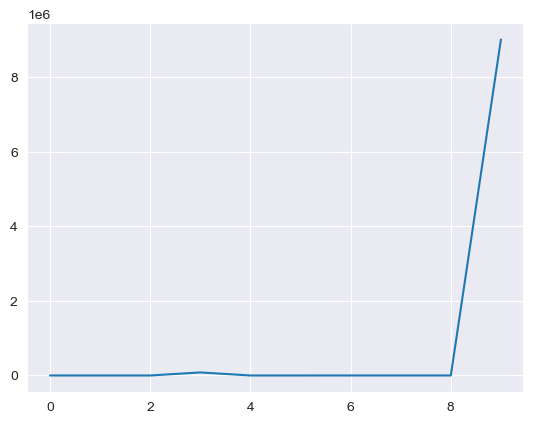

In [162]:
freq = zipf.rvs(a=1.1, loc=0, size=10)
print(freq)
plt.plot(freq)

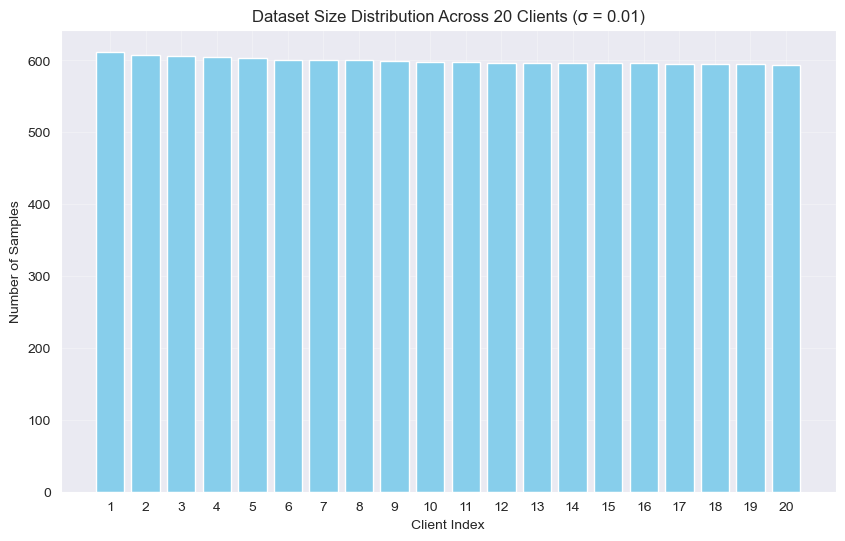

Client 1: 612 samples
Client 2: 608 samples
Client 3: 606 samples
Client 4: 604 samples
Client 5: 603 samples
Client 6: 601 samples
Client 7: 601 samples
Client 8: 600 samples
Client 9: 599 samples
Client 10: 598 samples
Client 11: 598 samples
Client 12: 597 samples
Client 13: 597 samples
Client 14: 596 samples
Client 15: 596 samples
Client 16: 596 samples
Client 17: 595 samples
Client 18: 595 samples
Client 19: 595 samples
Client 20: 594 samples


In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
num_clients = 20  # Number of clients
total_samples = 12000  # Total number of samples in the dataset
zipf_param = 0.01  # Zipf parameter (σ)

# Step 1: Calculate Zipf-based weights for clients
client_indices = np.arange(1, num_clients + 1)  # Client indices (1 to num_clients)
weights = 1 / (client_indices ** zipf_param)  # Zipf weights
weights /= weights.sum()  # Normalize to sum to 1

# Step 2: Assign dataset sizes to clients
client_dataset_sizes = (weights * total_samples).astype(int)

# Step 3: Simulate dataset partitioning
# Create a mock dataset with 'features' and 'labels'
np.random.seed(42)  # For reproducibility
mock_dataset = pd.DataFrame({
    'features': np.random.rand(total_samples, 3).tolist(),  # Example: 3 feature columns
    'labels': np.random.randint(0, 10, total_samples)  # Example: 10 classes
})

# Partition the dataset among clients
client_datasets = []
start_idx = 0
for size in client_dataset_sizes:
    client_datasets.append(mock_dataset.iloc[start_idx:start_idx + size])
    start_idx += size

# Step 4: Visualization
# Plot the dataset size distribution among clients
plt.figure(figsize=(10, 6))
plt.bar(client_indices, client_dataset_sizes, color='skyblue')
plt.title(f"Dataset Size Distribution Across {num_clients} Clients (σ = {zipf_param})")
plt.xlabel("Client Index")
plt.ylabel("Number of Samples")
plt.xticks(client_indices)
plt.grid(alpha=0.3)
plt.show()

# Print summary
for i, client_data in enumerate(client_datasets):
    print(f"Client {i+1}: {len(client_data)} samples")